In [ ]:
from google.colab import userdata, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow numpy -q
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

In [ ]:
# Define dataset paths
dataset_path = "/content/drive/MyDrive/dataset"
oral_cancer_path = os.path.join(dataset_path, "Oral Cancer photos")
normal_path = os.path.join(dataset_path, "normal")

In [ ]:
# Parameters
img_height, img_width = 224, 224  # Image dimensions
batch_size = 32
learning_rate = 0.001

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # brightness_range=[0.8, 1.2],
    # fill_mode='nearest',
    validation_split=0.05,
)

# No augmentation for validation data
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Data generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 1172 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.904320987654321, 1: 1.118320610687023}


In [ ]:
print("0 class:", len([i for i in train_generator.classes if i == 0]))
print("1 class:",len([i for i in train_generator.classes if i == 1]))

0 class: 648
1 class: 524


In [ ]:
# # Load pre-trained DenseNet121 model without the top layer
# base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# # Unfreeze some layers of the base model for fine-tuning
# base_model.trainable = False
# for layer in base_model.layers[:-10]:
#     layer.trainable = True

# # Add custom layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
# output = Dense(1, activation="sigmoid")(x)

# # Create the complete model
# model = Model(inputs=base_model.input, outputs=output)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
# base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# Compile the model
base_model.trainable = False  # Freeze the base model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights,
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
# Compile the model
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights,
    epochs=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9084 - loss: 0.2293 - val_accuracy: 0.7634 - val_loss: 0.5710


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.6885 - loss: 0.6909
Validation Loss: 0.4871, Validation Accuracy: 0.7846


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation data
y_pred = model.predict(validation_generator)
y_pred = np.round(y_pred).astype(int)

# Get true labels
y_true = validation_generator.labels

# Print classification report
print(classification_report(y_true, y_pred))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       136
           1       0.67      1.00      0.81       110

    accuracy                           0.78       246
   macro avg       0.84      0.81      0.78       246
weighted avg       0.85      0.78      0.78       246

[[ 83  53]
 [  0 110]]


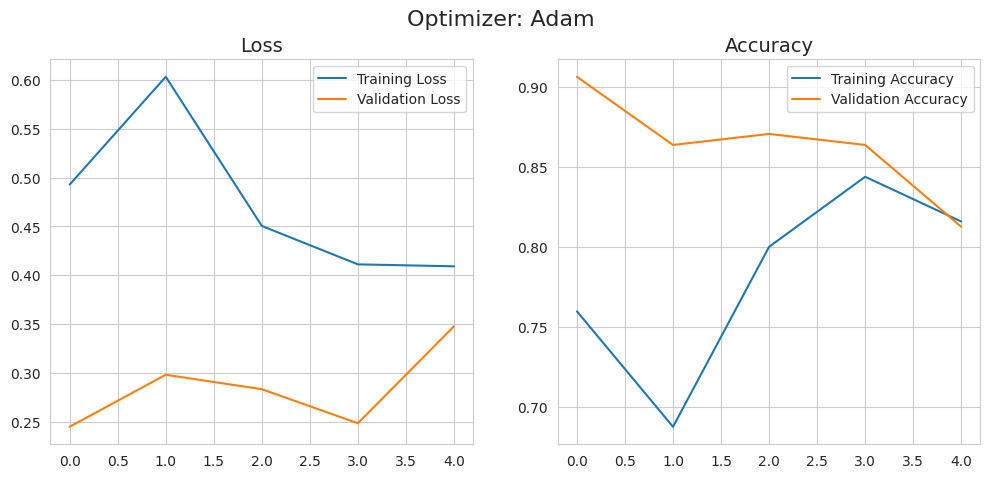

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss', fontsize=14)
ax1.legend()

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy', fontsize=14)
ax2.legend()

fig.suptitle('Optimizer: Adam', fontsize=16)
plt.show()

In [ ]:
# Save the model
model.save("oral_cancer_classification_modelV3.h5")

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model_path = "/content/oral_cancer_classification_modelV3.h5"
model = tf.keras.models.load_model(model_path)

# Parameters
img_height, img_width = 224, 224  # Same dimensions used during training

# Function to preprocess the image
def preprocess_image(image_path):
    # Load the image
    img = load_img(image_path, target_size=(img_height, img_width))
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Normalize pixel values (same preprocessing as training)
    img_array = img_array / 255.0
    # Add a batch dimension (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Perform inference on a new image
def predict_image(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    # Get the model's prediction
    prediction = model.predict(img_array)
    # Since the model uses sigmoid activation for binary classification,
    # the prediction is a probability value between 0 and 1.
    class_label = "Oral Cancer" if prediction[0][0] >= 0.5 else "Normal"
    confidence = prediction[0][0] if class_label == "Oral Cancer" else 1 - prediction[0][0]
    return class_label, confidence

# Example usage
image_path = "/content/drive/MyDrive/dataset/Oral Cancer photos/324950_1100.jpg"  # Replace with the path to your image
label, confidence = predict_image(image_path)
print(f"Prediction: {label}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Prediction: Oral Cancer
Confidence: 0.63
